# 목차

1. 개발환경
2. 시멘틱 세그멘테이션 데이터셋<br>
2-1. 데이터 로더(data loader) 만들기<br>
2-2. 이미지, 데이터 가져오기, augmentaion 적용<br>
2-3. 데이터셋 구성
3. 시맨틱 세그멘테이션 모델<br>
3-1. 모델 구조 만들기<br>
4.<br>
5.

## 1. 개발환경

In [1]:
import os
import math
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize # Albumentation에서 다양한 augmentation 기법을 확률적으로 적용

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

## 2. 시맨틱 세그멘테이션 데이터셋

모델을 학습시킬 수 있는 데이터 로더(data loader) 만들기<br>
로더는 입력값 (224, 224), 출력값 (224, 244) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야함.

### 2-1. 데이터 로더(data loader) 만들기

In [2]:
def build_augmentation(is_train=True):
    if is_train:
        return Compose([
            HorizontalFlip(p=0.5),
            RandomSizedCrop(
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(
                width=224,
                height=224
            )
        ])
    return Compose([
        Resize(
            width=224,
            height=224
        )
    ])

### 2-2. 이미지, 데이터 가져오기, augmentaion 적용

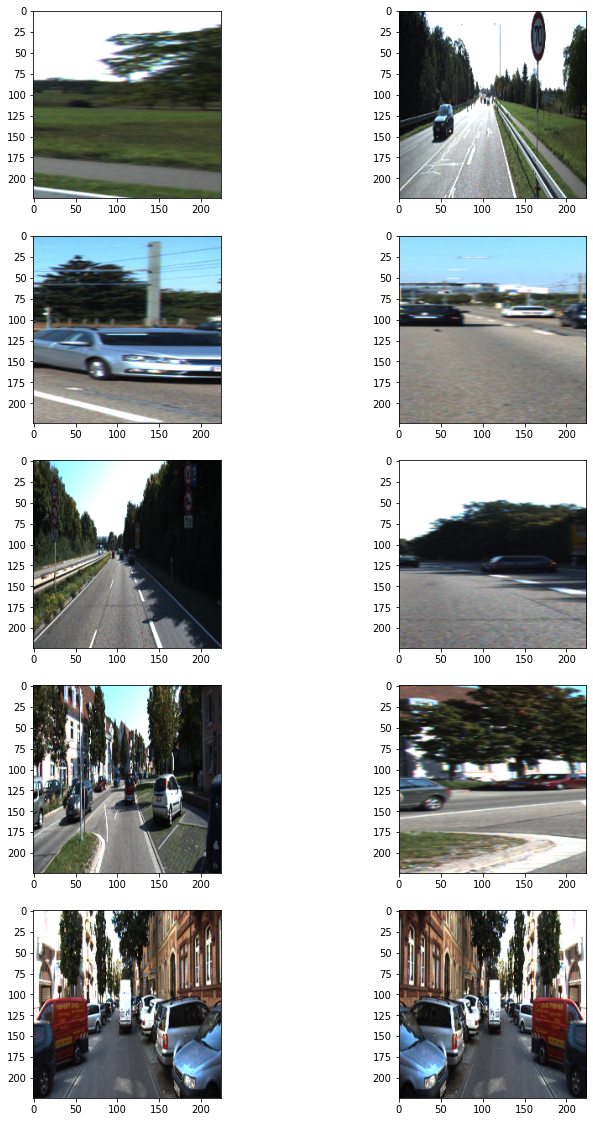

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image": image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])

plt.show()

### 2-3. 데이터셋 구성

tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    
    def __init__(self,
                 dir_path,
                 batch_size=4,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''

        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output == 7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

## 3. 시맨틱 세그멘테이션 모델

### 3-1. 모델 구조 만들기

In [6]:
def conv_batch(layer, filters):
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(layer)
    conv = Conv2D(filters, 3, activation='relu', padding='valid',kernel_initializer='he_normal')(conv)
    batch = BatchNormalization()(conv)
    
    return batch

In [7]:
def build_UNet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path
    conv1 = conv_batch(inputs, 64)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_batch(pool1, 128)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_batch(pool2, 256)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_batch(pool3, 512)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    # Expansive path
    up1 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge1 = concatenate([conv4,up1])
    conv6 = conv_batch(merge1, 512)

    up2 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3,up2])
    conv7 = conv_batch(merge2, 256)

    up3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2,up3])
    conv8 = conv_batch(merge3, 128)

    up4 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, up4])
    conv9 = conv_batch(merge4, 64)
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [8]:
UNet = build_UNet()
UNet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 220, 220, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 220, 220, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
UNet.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### 3-2. 모델 학습하기

In [12]:
UNet_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
UNet.save(UNet_model_path)

In [11]:
UNet.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

/opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 46s 131ms/step - loss: 0.8593 - val_loss: 0.7169
Epoch 2/100
43/43 [==============================] - 5s 122ms/step - loss: 0.7431 - val_loss: 0.6983
Epoch 3/100
43/43 [==============================] - 5s 122ms/step - loss: 0.7154 - val_loss: 0.7426
Epoch 4/100
43/43 [==============================] - 5s 123ms/step - loss: 0.6881 - val_loss: 0.7630
Epoch 5/100
43/43 [==============================] - 5s 124ms/step - loss: 0.6793 - val_loss: 0.7448
Epoch 6/100
43/43 [==============================] - 5s 124ms/step - loss: 0.6796 - val_loss: 0.7917
Epoch 7/100
43/43 [==============================] - 5s 124ms/step - loss: 0.6757 - val_loss: 0.8164
Epoch 8/100
43/43 [==============================] - 5s 125ms/step - loss: 0.6724 - val_loss: 0.7449
Epoch 9/100
43/43 [==============================] - 5s 126ms/step - loss: 0.6685 - val_loss: 0.7492
Epoch 10/100
43/43 [==============================] - 5s 126ms/step - loss: 0.6632 - val_l

## 4. 개선된 U-Net 모델 만들기

In [13]:
def build_UNet_plus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Contracting path(Backbone)
    conv1 = conv_batch(inputs, 64)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_batch(pool1, 128)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_batch(pool2, 256)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_batch(pool3, 512)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    batch5 = BatchNormalization()(conv5)
    
    
    # Re-designed skip pathways
    # conv1_1, conv2_1, conv3_1
    up_conv2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2.shape[1], up_conv2.shape[2]))
    merge1_1 = concatenate([skip_crop_conv1, up_conv2])
    conv1_1 = conv_batch(merge1_1, 64)
    
    up_conv3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3.shape[1], up_conv3.shape[2]))
    merge2_1 = concatenate([skip_crop_conv2 , up_conv3])
    conv2_1 = conv_batch(merge2_1, 128)
    
    up_conv4 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv4))
    skip_crop_conv3 = tf.image.resize(conv3, (up_conv4.shape[1], up_conv4.shape[2]))
    merge3_1 = concatenate([skip_crop_conv3, up_conv4])
    conv3_1 = conv_batch(merge3_1, 256)
    
    # conv1_2, conv2_2
    up_conv2_1 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_1))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_1.shape[1], up_conv2_1.shape[2]))
    merge1_2 = concatenate([skip_crop_conv1, skip_crop_conv1_1, up_conv2_1])
    conv1_2 = conv_batch(merge1_2, 64)
    
    up_conv3_1 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv3_1))
    skip_crop_conv2 = tf.image.resize(conv2, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    skip_crop_conv2_1 = tf.image.resize(conv2_1, (up_conv3_1.shape[1], up_conv3_1.shape[2]))
    merge2_2 = concatenate([skip_crop_conv2, skip_crop_conv2_1, up_conv3_1])
    conv2_2 = conv_batch(merge2_2, 256)

    # conv1_3
    up_conv2_2 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv2_2))
    skip_crop_conv1 = tf.image.resize(conv1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_1 = tf.image.resize(conv1_1, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    skip_crop_conv1_2 = tf.image.resize(conv1_2, (up_conv2_2.shape[1], up_conv2_2.shape[2]))
    merge1_3 = concatenate([skip_crop_conv1, skip_crop_conv1_1, skip_crop_conv1_2, up_conv2_2])
    conv1_3 = conv_batch(merge1_3, 64)
    
    
    # Expansive path
    up1 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch5)) 
    merge1 = concatenate([conv4,up1])
    conv6 = conv_batch(merge1, 512)

    up2 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    crop_conv3 = tf.image.resize(conv3, (up2.shape[1], up2.shape[2]))
    crop_conv3_1 = tf.image.resize(conv3_1, (up2.shape[1], up2.shape[2]))
    merge2 = concatenate([crop_conv3, crop_conv3_1, up2])
    conv7 = conv_batch(merge2, 256)

    up3 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    crop_conv2 = tf.image.resize(conv2, (up3.shape[1], up3.shape[2]))
    crop_conv2_1 = tf.image.resize(conv2_1, (up3.shape[1], up3.shape[2]))
    crop_conv2_2 = tf.image.resize(conv2_2, (up3.shape[1], up3.shape[2]))
    merge3 = concatenate([crop_conv2, crop_conv2_1, crop_conv2_2, up3])
    conv8 = conv_batch(merge3, 128)

    up4 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    crop_conv1 = tf.image.resize(conv1, (up4.shape[1], up4.shape[2]))
    crop_conv1_1 = tf.image.resize(conv1_1, (up4.shape[1], up4.shape[2]))
    crop_conv1_2 = tf.image.resize(conv1_2, (up4.shape[1], up4.shape[2]))
    crop_conv1_3 = tf.image.resize(conv1_3, (up4.shape[1], up4.shape[2]))
    merge4 = concatenate([crop_conv1, crop_conv1_1, crop_conv1_2, crop_conv1_3, up4])
    conv9 = conv_batch(merge4, 64)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    conv10 = tf.image.resize(conv10, (input_shape[0], input_shape[1]))

    model = Model(inputs = inputs, outputs = conv10)
    
    return model

In [14]:
UNet_plus = build_UNet_plus()
UNet_plus.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 222, 222, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 220, 220, 64) 36928       conv2d_23[0][0]                  
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 220, 220, 64) 256         conv2d_24[0][0]                  
____________________________________________________________________________________________

In [16]:
UNet_plus.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
UNet_plus.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

/opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 29s 420ms/step - loss: 0.4862 - val_loss: 0.5153
Epoch 2/100
43/43 [==============================] - 18s 412ms/step - loss: 0.3771 - val_loss: 0.4168
Epoch 3/100
43/43 [==============================] - 17s 406ms/step - loss: 0.3563 - val_loss: 0.3187
Epoch 4/100
43/43 [==============================] - 17s 402ms/step - loss: 0.3387 - val_loss: 0.4958
Epoch 5/100
43/43 [==============================] - 17s 403ms/step - loss: 0.3197 - val_loss: 0.6163
Epoch 6/100
43/43 [==============================] - 17s 404ms/step - loss: 0.3102 - val_loss: 0.5895
Epoch 7/100
43/43 [==============================] - 17s 406ms/step - loss: 0.3027 - val_loss: 0.3928
Epoch 8/100
43/43 [==============================] - 17s 405ms/step - loss: 0.3128 - val_loss: 0.1830
Epoch 9/100
43/43 [==============================] - 17s 404ms/step - loss: 0.3027 - val_loss: 0.3916
Epoch 10/100
43/43 [==============================] - 17s 403ms/step - loss: 0.301

In [18]:
UNet_plus_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
UNet.save(UNet_plus_model_path)

In [19]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return

In [20]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    
    plt.figure(figsize=(12, 20))
    plt.imshow(output)

    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

# 5. 시각화

U-Net

IoU : 0.539396


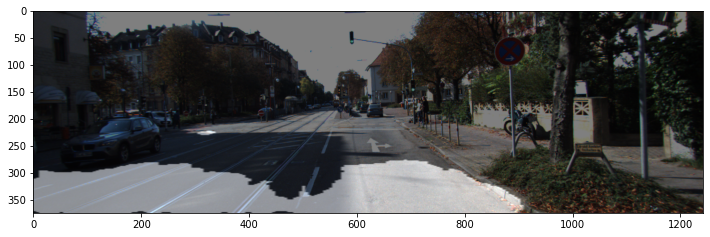

In [22]:
i = 1
output, prediction, target = get_output(
     UNet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

U++ Net

IoU : 0.711426


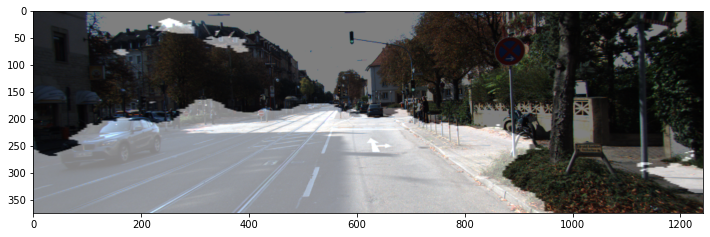

In [21]:
i = 1
output, prediction, target = get_output(
     UNet_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

# 6. 회고

결론: IOU값, Unet+:0.71, Unet:0.54 .<br>
Skip pathways와 deep supervision이 적용된 Unet++ 구조가 더 높은 성능을 보인다.<br>

Unet+는 기본적으로 깊게 지도학습(deeply-supervised)된 인코더-디코더 네트워크이다.<br> 
스킵 커넥션은 타겟 오브젝트의 세밀한 디테일을 잡아내는 것에 효율적인데 이 인코더-디코더의 서브 네트워크들 안에 hierarchical하게 구성된 dense skip pathways들이 Unet+의 기본 골격을 구성한다.<br>
Unet+는 인코더-디코더의 서브네트워크들의 특성 맵 사이의 'gap'을 줄이는 것에 주안점을 둔것 같다.<br>

논문의 결과에 따르면 UNet++은 메디컬 이미징 세그멘테이션에 좋은 효율을 보였다고 하며 현재 현업에서도 많이 이용되고 있는 것 같다.<br>
실험 결과로 확인된 분야는 폐의 결절을 확인하는 세그멘테이션, 대장 용종을 보는 세그멘테이션, 세포의 핵을 구별하는 세그멘테이션, 간 세그멘테이션.<br>
브레인 분야에서도 많이 사용될 것 같아 논문을 찬찬히 다시 읽어보려고 한다.
